In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
import itertools
from pprint import pprint
from mnk import MNK

In [34]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [35]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    return f, p

In [36]:
df = pd.read_csv("DataSet1_4.csv", sep=',')
df = df.dropna()

df["Day"] = pd.to_datetime(df["Day"])
df["Day"] = norm(df["Day"].values.astype("float64"))

df = df.drop(columns=[
    'Entity', 'Code', 'Year', 'Continent'
])
df = df.drop_duplicates()
df = df.reset_index(drop=True)

df = df.groupby(by="Day").sum()
df = df.reset_index()

predict_column = "Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)"

columns = list(df.columns)
columns.remove(predict_column)
columns = [predict_column] + columns
columns = pd.Index(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 3 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Day                                                                               818 non-null    float64
 1   Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)  818 non-null    float64
 2   Total confirmed cases of COVID-19                                                 818 non-null    float64
dtypes: float64(3)
memory usage: 19.3 KB


In [37]:
df

,Day,"Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)",Total confirmed cases of COVID-19
0,0.000000,833.834,5560.0
1,0.001224,798.262,6144.0
2,0.002448,1079.930,8215.0
3,0.003672,1280.644,9907.0
4,0.004896,1512.356,12022.0
...,...,...,...
813,0.995104,731905.735,507044513.0
814,0.996328,704074.263,488525090.0
815,0.997552,709843.402,488164352.0
816,0.998776,689062.757,480520034.0


In [38]:
df.nunique()

Day                                                                                 818
Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)    818
Total confirmed cases of COVID-19                                                   818
dtype: int64

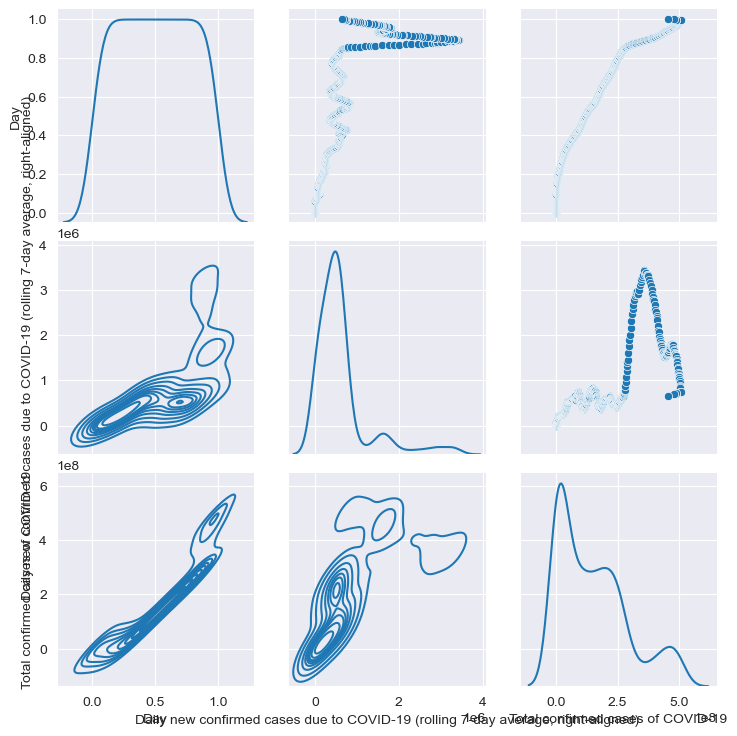

In [39]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.show()

# Sample

In [40]:
sample = df.sample(
    # 5
    int(len(df) * 0.3)
)
sample = sample.drop_duplicates(subset=[predict_column])
indexes = df.index.delete(df.index.isin(sample.index))
sample = sample.sort_values(by=predict_column)
sample = sample.reset_index(drop=True)
X = sample.loc[0:len(sample), columns[~columns.isin([predict_column])]].to_numpy()
y = sample.loc[0:len(sample), [predict_column]].to_numpy()

In [41]:
sample

,Day,"Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)",Total confirmed cases of COVID-19
0,0.034272,722.144,79644.0
1,0.035496,793.476,80581.0
2,0.000000,833.834,5560.0
3,0.033048,863.452,78827.0
4,0.039168,1039.620,85226.0
...,...,...,...
240,0.878825,2957692.993,326765065.0
241,0.902081,2999150.859,388418974.0
242,0.884945,3172451.286,343159449.0
243,0.895961,3329965.281,373094025.0


# МНК

In [42]:
funcs = [
    lambda x: x[0] ** 0,
    lambda x: x[0],
    lambda x: x[0] ** 2,
    lambda x: x[1],
    lambda x: x[1] ** 2,
    # lambda x: x[2],
    # lambda x: x[2] ** 2,
    # lambda x: x[3],
    # lambda x: x[3] ** 2,
    # lambda x: x[4],
    # lambda x: x[4] ** 2,
    # lambda x: x[5],
    # lambda x: x[5] ** 2,
    # lambda x: x[6],
    # lambda x: x[6] ** 2,
]
# funcs[1](df.loc[:, 1:6].to_numpy().T), funcs[16](df.loc[:, 1:6].to_numpy().T)
mnk = MNK(sample.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T, sample[predict_column].values, funcs)
# mnk = MNK(df.loc[:, 1:6].to_numpy().T, df[7].values, funcs)
mnk.c

array([ 1.23562331e+05, -1.68633010e+05,  6.46991632e+04,  4.24255190e-03,
       -1.97834074e-12])

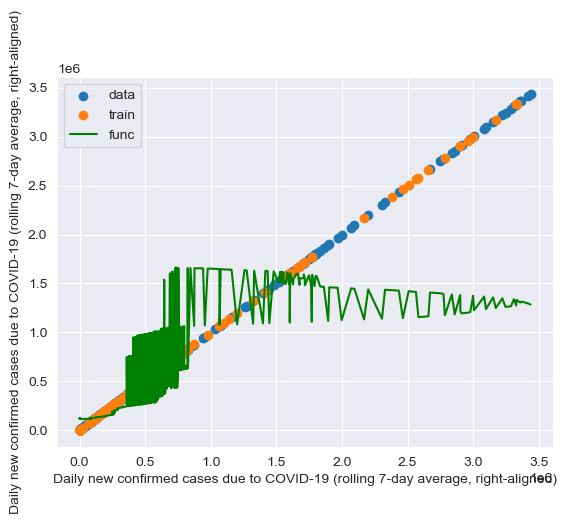

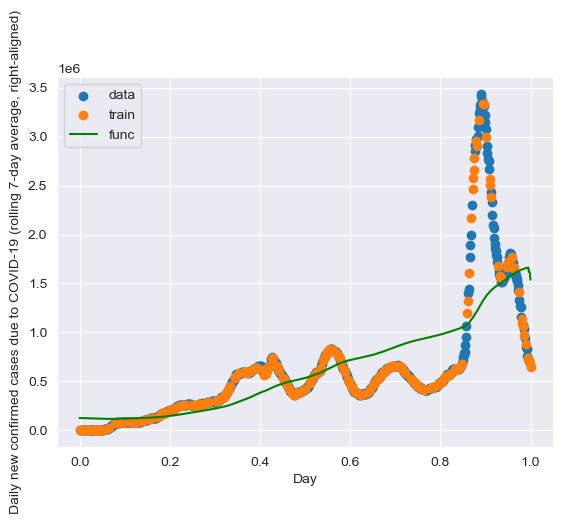

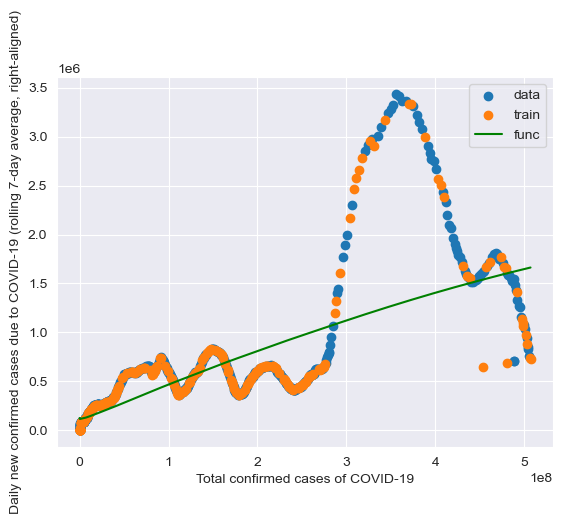

In [43]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], mnk(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T), label='func', color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T)
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

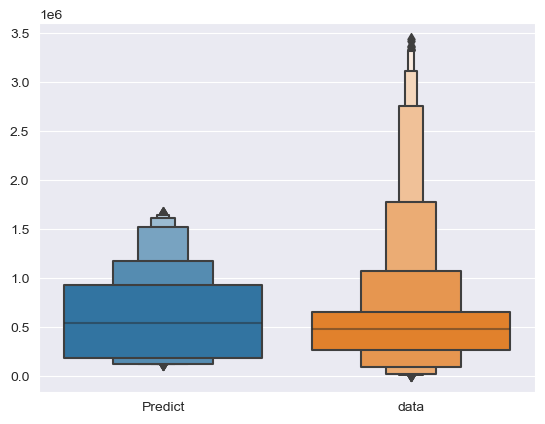

In [44]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

In [45]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.20240632840582906, pvalue=0.8396242790421857)
F-test   stat = 0.4875589101325911, pvalue = 1.0
X2       stat = 68231940.74831253, pvalue = 0.0


# kNN

In [46]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

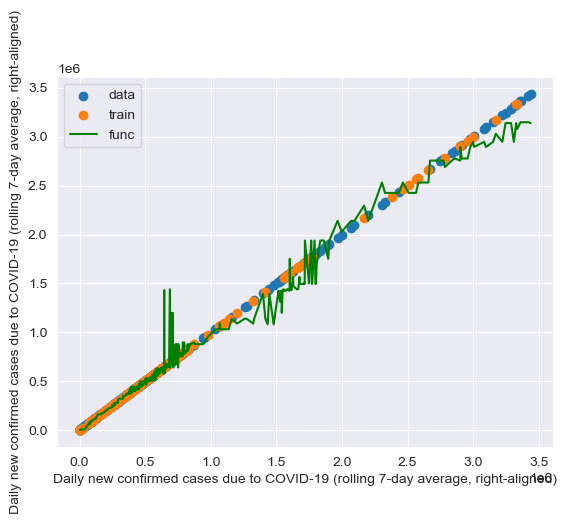

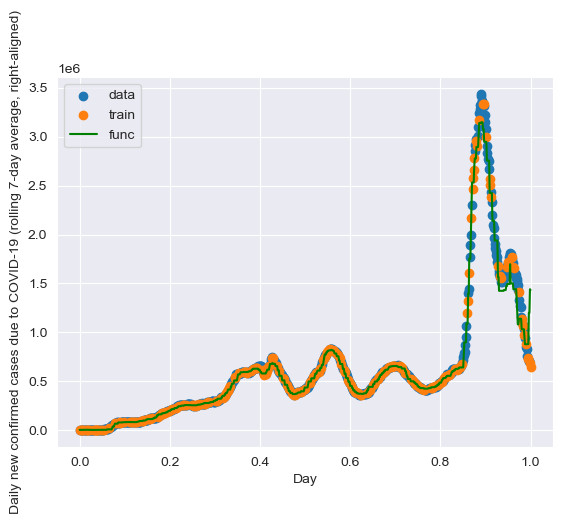

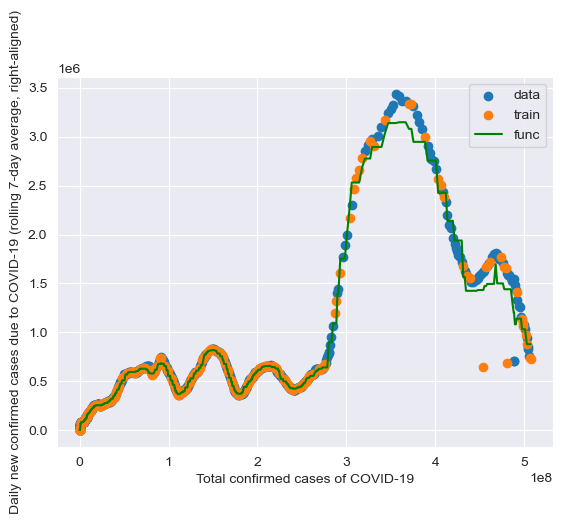

In [47]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], neigh.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = neigh.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

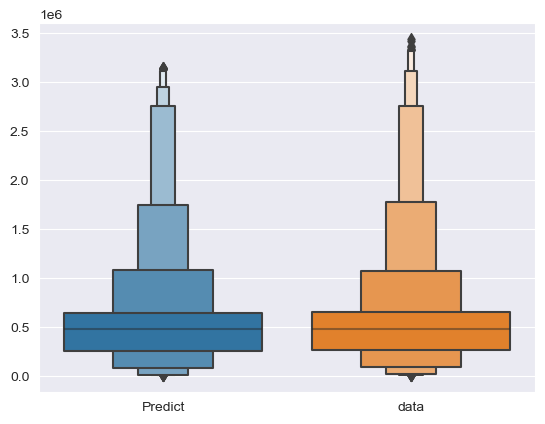

In [48]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

In [49]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.4454740124236334, pvalue=0.6560362477896236)
F-test   stat = 0.9127372524161942, pvalue = 0.9039345511415395
X2       stat = 1913384.329417816, pvalue = 0.0


# Lasso

In [50]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)
lasso.fit(X, y)

Lasso(alpha=0.5)

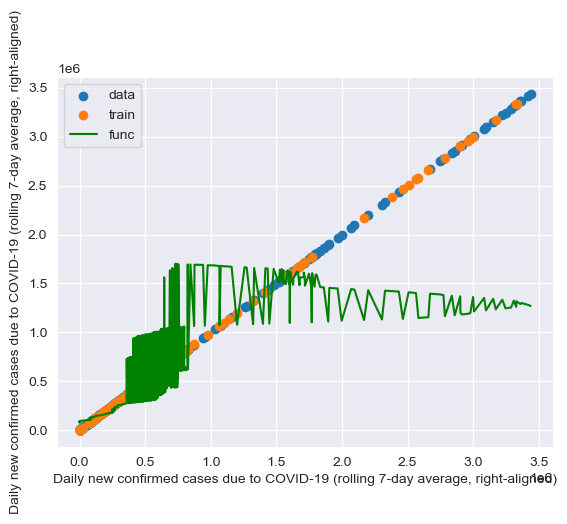

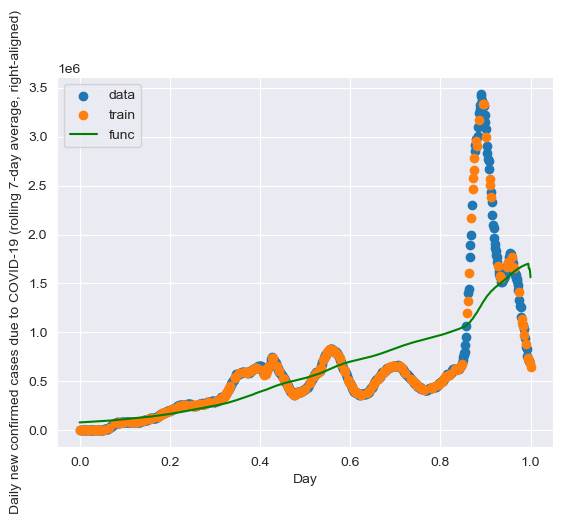

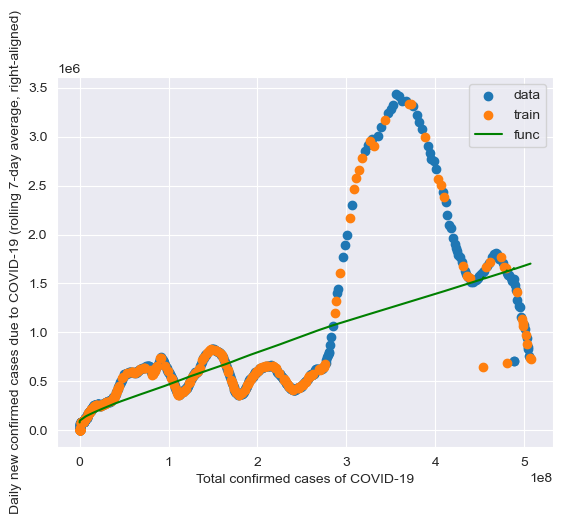

In [51]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], lasso.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = lasso.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())

<AxesSubplot:>

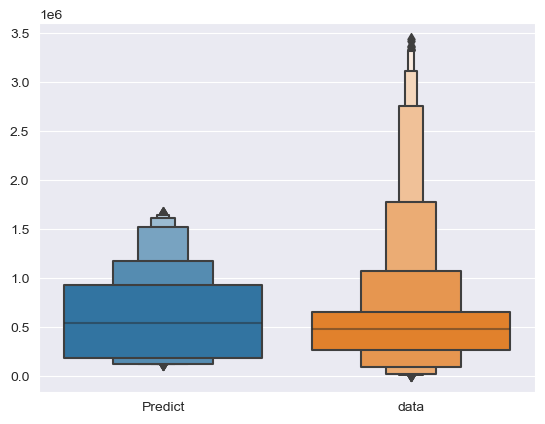

In [52]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

In [53]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.18370936055856002, pvalue=0.8542642587749918)
F-test   stat = 0.48396940458614257, pvalue = 1.0
X2       stat = 64450948.64288091, pvalue = 0.0


# Ridge

In [54]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X, y)

C:\Users\kolya\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.53961e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge(alpha=0.5)

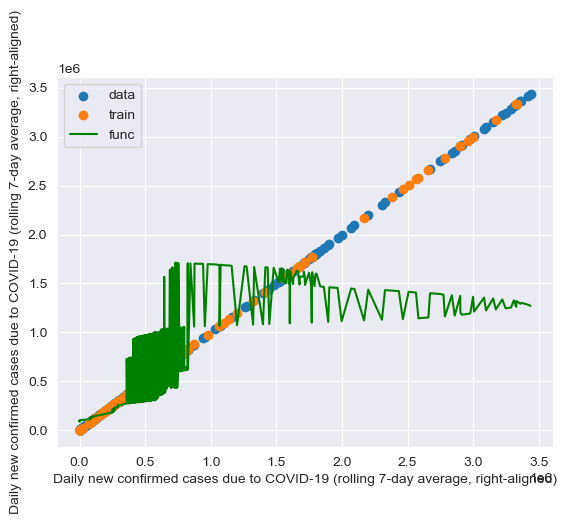

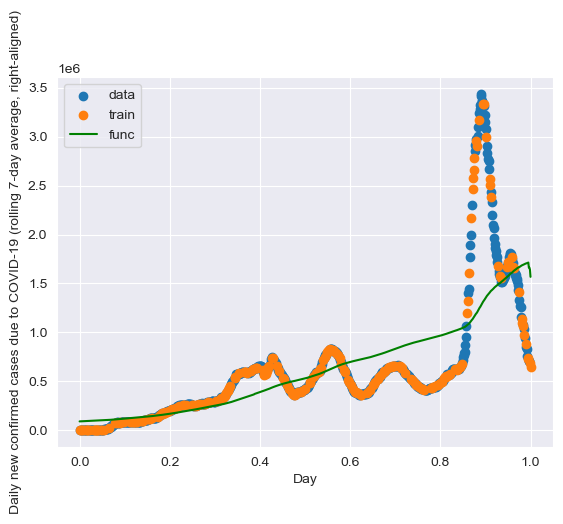

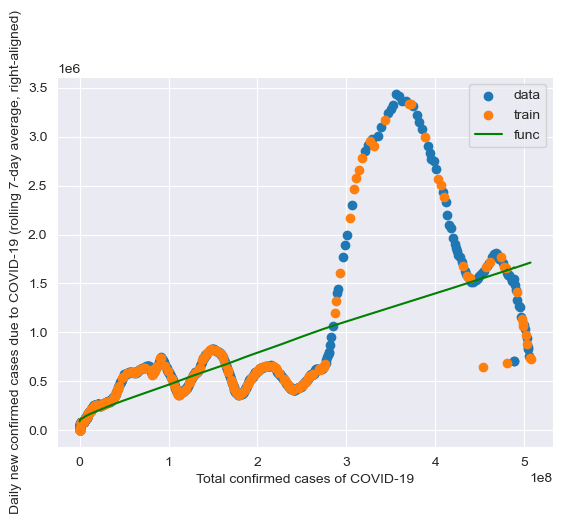

In [55]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], ridge.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = ridge.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

<AxesSubplot:>

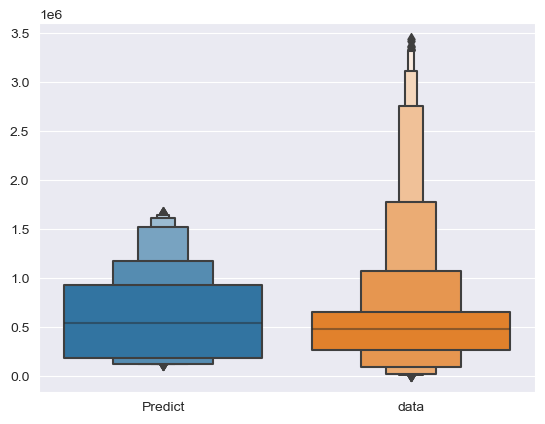

In [56]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

In [57]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.17857451395531124, pvalue=0.8582939448633091)
F-test   stat = 0.48380751453118803, pvalue = 1.0
X2       stat = 64865262.60866296, pvalue = 0.0
